# Cross-Validation for Best Hyperparameters

This notebook illustrates how to use cross-validation to help select hyperparameters of an ML model that achieve the best possible accuracy.


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import json
from tqdm import tqdm

## Load the data

### Here the data set will be downloaded

In [14]:
training_set = torchvision.datasets.FashionMNIST('./data', train=True, download=True)
X_train, y_train = training_set.data, training_set.targets

validation_set = torchvision.datasets.FashionMNIST('./data', train=False, download=True)
X_test, y_test = validation_set.data, validation_set.targets

# Class labels
classes = np.array(training_set.classes)

In [15]:
print(f'The training set has shape {X_train.shape} with label shape {y_train.shape}.')

print(f'The validation set has shape {X_test.shape} with label shape {y_test.shape}.')

print(f'There are the following classes in the data set {classes}.')

The training set has shape torch.Size([60000, 28, 28]) with label shape torch.Size([60000]).
The validation set has shape torch.Size([10000, 28, 28]) with label shape torch.Size([10000]).
There are the following classes in the data set ['T-shirt/top' 'Trouser' 'Pullover' 'Dress' 'Coat' 'Sandal' 'Shirt'
 'Sneaker' 'Bag' 'Ankle boot'].


## Visualise the data to get an intuition for the data set

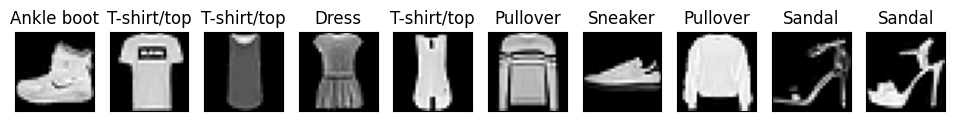

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(12,4), subplot_kw=dict(xticks=[], yticks=[]))
for i in np.arange(10):
    ax[i].imshow(X_train[i,:], cmap=plt.cm.gray)
    ax[i].set_title(classes[y_train[i]])

In [17]:
print(f'The first 10 labels before removing classes: {classes[np.array(y_train[0:10], dtype=np.int32).ravel()]}')

def extract_class(X, y, iClass):
    i1 = np.where(y == iClass)[0]
    X_ = X[i1, :]
    Y_ = iClass * np.ones((X_.shape[0], 1))
    return X_, Y_

X_train1, y_train1 = extract_class(X_train, y_train, 1)
X_train2, y_train2 = extract_class(X_train, y_train, 2)

# concatenate data
X_train = np.concatenate((X_train1, X_train2), axis=0)
y_train = np.concatenate((y_train1, y_train2), axis=0)

X_test1, y_test1 = extract_class(X_test, y_test, 1)
X_test2, y_test2 = extract_class(X_test, y_test, 2)

# concatenate data
X_test = np.concatenate((X_test1, X_test2), axis=0)
y_test = np.concatenate((y_test1, y_test2), axis=0)

print(f'The first 10 labels after removing classes: {classes[np.array(y_train[0:10], dtype=np.int32).ravel()]}')


The first 10 labels before removing classes: ['Ankle boot' 'T-shirt/top' 'T-shirt/top' 'Dress' 'T-shirt/top' 'Pullover'
 'Sneaker' 'Pullover' 'Sandal' 'Sandal']
The first 10 labels after removing classes: ['Trouser' 'Trouser' 'Trouser' 'Trouser' 'Trouser' 'Trouser' 'Trouser'
 'Trouser' 'Trouser' 'Trouser']


In [18]:
X_train = X_train.reshape((-1, 28*28))
X_test =  X_test.reshape((-1, 28*28))
print(f'The training set now has the shape {X_train.shape}.')
print(f'The validation set now has the shape {X_test.shape}.')

The training set now has the shape (12000, 784).
The validation set now has the shape (2000, 784).


## Define parameters for all algorithms.

### Linear Regression

In [13]:
penalties = ["l1", "l2"]
C = [1, 2, 5, 10]

lr_parameters = []
for penalty in penalties:
    for c in C:
        lr_parameters.append({"penalty": penalty, "C": c})
    
print(lr_parameters)

[{'penalty': 'l1', 'C': 1}, {'penalty': 'l1', 'C': 2}, {'penalty': 'l1', 'C': 5}, {'penalty': 'l1', 'C': 10}, {'penalty': 'l2', 'C': 1}, {'penalty': 'l2', 'C': 2}, {'penalty': 'l2', 'C': 5}, {'penalty': 'l2', 'C': 10}]


### Non-linear Regression

In [14]:
penalties = ["l1", "l2"]
C = [1, 2, 5, 10]
degrees = [2**i for i in range(2, 4)]

non_lr_parameters = []
for penalty in penalties:
    for c in C:
        for degree in degrees:
            non_lr_parameters.append({"penalty": penalty, "C": c, "degree": degree})
    
print(non_lr_parameters)

[{'penalty': 'l1', 'C': 1, 'degree': 4}, {'penalty': 'l1', 'C': 1, 'degree': 8}, {'penalty': 'l1', 'C': 2, 'degree': 4}, {'penalty': 'l1', 'C': 2, 'degree': 8}, {'penalty': 'l1', 'C': 5, 'degree': 4}, {'penalty': 'l1', 'C': 5, 'degree': 8}, {'penalty': 'l1', 'C': 10, 'degree': 4}, {'penalty': 'l1', 'C': 10, 'degree': 8}, {'penalty': 'l2', 'C': 1, 'degree': 4}, {'penalty': 'l2', 'C': 1, 'degree': 8}, {'penalty': 'l2', 'C': 2, 'degree': 4}, {'penalty': 'l2', 'C': 2, 'degree': 8}, {'penalty': 'l2', 'C': 5, 'degree': 4}, {'penalty': 'l2', 'C': 5, 'degree': 8}, {'penalty': 'l2', 'C': 10, 'degree': 4}, {'penalty': 'l2', 'C': 10, 'degree': 8}]


### Perceptron

In [15]:
max_iters = [5, 10, 50, 100, 250, 500, 1000, 2500] 
penalties = ["l1", "l2", "elasticnet", None]
alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1]
l1_ratios = [0.1, 0.25, 0.5, 0.75, 0.9]
shuffles = [True, False]

perceptron_parameters = []

for max_iter in max_iters:
    for shuffle in shuffles:
        for penalty in penalties:
            perceptron_parameters.append({"max_iter": max_iter, "shuffle": shuffle, "penalty": penalty})
            if penalty:
                for alpha in alphas:
                    perceptron_parameters[-1]["alpha"] = alpha
                if penalty == "elasticnet":
                    for l1_ratio in l1_ratios: 
                        perceptron_parameters[-1]["l1_ratio"] = l1_ratio
print(perceptron_parameters)


[{'max_iter': 5, 'shuffle': True, 'penalty': 'l1', 'alpha': 0.1}, {'max_iter': 5, 'shuffle': True, 'penalty': 'l2', 'alpha': 0.1}, {'max_iter': 5, 'shuffle': True, 'penalty': 'elasticnet', 'alpha': 0.1, 'l1_ratio': 0.9}, {'max_iter': 5, 'shuffle': True, 'penalty': None}, {'max_iter': 5, 'shuffle': False, 'penalty': 'l1', 'alpha': 0.1}, {'max_iter': 5, 'shuffle': False, 'penalty': 'l2', 'alpha': 0.1}, {'max_iter': 5, 'shuffle': False, 'penalty': 'elasticnet', 'alpha': 0.1, 'l1_ratio': 0.9}, {'max_iter': 5, 'shuffle': False, 'penalty': None}, {'max_iter': 10, 'shuffle': True, 'penalty': 'l1', 'alpha': 0.1}, {'max_iter': 10, 'shuffle': True, 'penalty': 'l2', 'alpha': 0.1}, {'max_iter': 10, 'shuffle': True, 'penalty': 'elasticnet', 'alpha': 0.1, 'l1_ratio': 0.9}, {'max_iter': 10, 'shuffle': True, 'penalty': None}, {'max_iter': 10, 'shuffle': False, 'penalty': 'l1', 'alpha': 0.1}, {'max_iter': 10, 'shuffle': False, 'penalty': 'l2', 'alpha': 0.1}, {'max_iter': 10, 'shuffle': False, 'penalty'

### Support Vector Machine

In [16]:
C = [2, 5]
kernels = ["linear", "rbf"]
gammas = ["scale", "auto"]

svm_parameters = []

for c in C:
    for kernel in kernels:
        for gamma in gammas:
            svm_parameters.append({"C": c, "kernel": kernel, "gamma": gamma})
print(svm_parameters)

[{'C': 2, 'kernel': 'linear', 'gamma': 'scale'}, {'C': 2, 'kernel': 'linear', 'gamma': 'auto'}, {'C': 2, 'kernel': 'rbf', 'gamma': 'scale'}, {'C': 2, 'kernel': 'rbf', 'gamma': 'auto'}, {'C': 5, 'kernel': 'linear', 'gamma': 'scale'}, {'C': 5, 'kernel': 'linear', 'gamma': 'auto'}, {'C': 5, 'kernel': 'rbf', 'gamma': 'scale'}, {'C': 5, 'kernel': 'rbf', 'gamma': 'auto'}]


## Implementation of the Non-Linear Regression

In [17]:
class non_linear_LogisticRegression():
    def __init__(self, parameters):
        pars = parameters.copy()
        self.degree = pars["degree"]
        del pars["degree"]
        self.lr = LogisticRegression(**pars, solver = "liblinear")

    def fit(self, X, y):
        X_ = PolynomialFeatures(self.degree).fit_transform(X)
        self.lr.fit(X_, y)

    def predict(self, X):
        return self.lr.predict(X)


## Peform the grid-search using cross validation

In [18]:
def CV(X, y, model, K=10):
    accuracy_CV = 0
    N = X.shape[0]
    permutation =  np.random.permutation(N)
    X_perm = X[permutation]
    y_perm = y[permutation]

    slice_size = N // K
    for k in range(K):
        i_lower = k * slice_size
        i_upper = k * slice_size + slice_size
        mask = np.arange(i_lower, i_upper)
        X_train_ = np.delete(X_perm, mask, axis=0)
        X_val = X_perm[mask]
        y_train = np.delete(y_perm, mask)
        y_val = y_perm[mask]
        model.fit(X_train_, y_train)
        y_hat = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_hat)
        accuracy_CV += accuracy
    accuracy_CV /= K

    return accuracy_CV

best_accuracies = {}

In [19]:
accuracies_lr = []
for parameters in lr_parameters:
    model = LogisticRegression(**parameters, solver = "liblinear")
    accur = CV(X_train, y_train, model, K=5)
    accuracies_lr.append(accur)

max_index_lr = np.argmax(accuracies_lr)
best_pars_lr = lr_parameters[max_index_lr]
best_accur_lr = accuracies_lr[max_index_lr]

print(f'Best accuracy {best_accur_lr} with parameteres {best_pars_lr}')

best_model_lr = LogisticRegression(**best_pars_lr, solver = "liblinear").fit(X_train, y_train)
y_hat = best_model_lr.predict(X_test)
test_accuracy_lr = accuracy_score(y_test, y_hat)

best_accuracies["LogisticRegression"] = {"train_accuracy": best_accur_lr, "test_accuracy": test_accuracy_lr}

Best accuracy 0.9933333333333334 with parameteres {'penalty': 'l1', 'C': 2}


/Users/oliverpreuss/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [20]:
accuracies_perceptron = []
for parameters in perceptron_parameters:
    model = Perceptron(**parameters)
    accur = CV(X_train, y_train, model, K=5)
    accuracies_perceptron.append(accur)

max_index_perceptron = np.argmax(accuracies_perceptron)
best_pars_perceptron = perceptron_parameters[max_index_perceptron]
best_accur_perceptron = accuracies_perceptron[max_index_perceptron]
print(f'Best accuracy {best_accur_perceptron} with parameteres {best_pars_perceptron}')

best_model_perc = Perceptron(**parameters).fit(X_train, y_train)
y_hat = best_model_perc.predict(X_test)
test_accuracy_perc = accuracy_score(y_test, y_hat)

best_accuracies["Perceptron"] = {"train_accuracy": best_accur_perceptron, "test_accuracy": test_accuracy_perc}

/Users/oliverpreuss/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/oliverpreuss/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/oliverpreuss/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/oliverpreuss/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warning

Best accuracy 0.9919166666666668 with parameteres {'max_iter': 2500, 'shuffle': False, 'penalty': None}


/Users/oliverpreuss/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [21]:
# accuracies_svm = []
# for parameters in svm_parameters:
#     model = SVC(**parameters)
#     accur = CV(X_train, y_train, model, K=5)
#     accuracies_svm.append(accur)

# max_index_svm = np.argmax(accuracies_svm)
# best_pars_svm = perceptron_parameters[max_index_svm]
# best_accur_svm = accuracies_perceptron[max_index_svm]
# print(f'Best accuracy {best_accur_svm} with parameteres {best_pars_svm}')

# best_model_svm = SVC(**parameters).fit(X_train, y_train)
# y_hat = best_model_svm.predict(X_test)
# test_accuracy_svm = accuracy_score(y_test, y_hat)

# best_accuracies["SVC"] = {"train_accuracy": best_accur_svm, "test_accuracy": test_accuracy_svm}

## Use sklearn gird-serach implementation
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [ ]:
C = [2, 5]
kernels = ["linear", "rbf"]
gammas = ["scale", "auto"]
svm_parameters = {"C": C, "kernel": kernels, "gamma": gammas}

gs_svm = GridSearchCV(SVC(),
                      param_grid=svm_parameters,
                      scoring='accuracy',
                      cv=5,
                      n_jobs=-1)

gs_svm.fit(X_train, y_train.ravel())

best_pars_svm = gs_svm.best_params_
best_model_svm = SVC(**best_pars_svm).fit(X_train, y_train.ravel())
best_accur_svm = accuracy_score(y_train, best_model_svm.predict(X_train))
print(f'Best accuracy {best_accur_svm} with parameteres {best_pars_svm}')

y_hat = best_model_svm.predict(X_test)
test_accuracy_svm = accuracy_score(y_test, y_hat)

best_accuracies["SVC"] = {"train_accuracy": best_accur_svm, "test_accuracy": test_accuracy_svm}

In [23]:
svm = SVC(C=2,kernel="rbf",gamma="auto")
svm.fit(X_train, y_train.ravel())
svm.score(X_test, y_test.ravel())

0.5

In [ ]:
print(json.dumps(best_accuracies, indent=2))